# Packages

In [1150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from decimal import Decimal, ROUND_DOWN

# Data & Functions

## Today's DateTime

In [1151]:
current_dt = datetime.now() # current date and time
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"] # list of months

## Format Amount

Amounts for each item should be properly formatted. There are two functions for this, but they are processed differently due to analytical reasons.

- `truncate_amount()`: Eliminates values that are placed more than 2 times after the decimal points. However, it must return as a <u>Decimal</u> since the **Revenue** column from the DataFrame contains decimals, not strings.

- `format_amount()`: Formats the amount properly and returns it as a <u>string</u>. 

In [1152]:
def truncate_amount(amount: float | Decimal) -> Decimal:
    """
    Truncates decimal places with displaying only two numbers after the decimal point

    Args:
        amount (float | Decimal): item amount

    Returns:
        Decimal: item amount with exactly two numbers after the decimal point
    """
    return Decimal(amount).quantize(Decimal('0.00'), rounding=ROUND_DOWN)

In [1153]:
def format_amount(amount: Decimal) -> str:
    """
    Formats amount to a string by adding '$'
    followed by the amount with the option to
    add 0's after the decimal point.

    Args:
        amount (Decimal): item amount

    Returns:
        str: stringified amount
    """
    return f'${amount:.2f}'

## DataFrames

### Ceil Maximum Value

When getting all values from a column, **ceiled maximum value** is <u>greater than the maximum value</u>. The **multiplier** creates a gap between the max value and ceiled max value, which is the multiple of the multiplier. By default, it ceils the maximum value and then gets added by 1.

---

**Use Cases:**
    
1. Adding and ranging y-ticks by adding a gap between the max value and its ceil in a bar graph.

---

**Examples:**

***Note:** 0.1 is added to max values for proper ceiling*

**Example 1**:

`max = 10.1, multiplier = 1, inclusive = True`

$10.1 * 1 = 10.1$ → $ceil(10.1) = 11$ → $11 * 1 = 11$ → $11 + 1 = 12$

**12** is the ceiled maximum value. When plotting a bar graph, the y-ticks range from 0 to 11.

**Example 2**:

`max = 10.1, multiplier = 10, inclusive = True`

$10.1 * \frac{1}{10} = 1.01$ → $ceil(1.01) = 2$ → $2 * 10 = 20$ → $20 + 1 = 21$

**21** is the ceiled maximum value. When plotting a bar graph, the y-ticks range from 0 to 20.

**Example 3**:

`max = 10.1, multiplier = 100, inclusive = True`

$10.1 * \frac{1}{100} = .101$ → $ceil(.101) = 1$ → $1 * 100 = 100$ → $100 + 1 = 101$

**101** is the ceiled maximum value. When plotting a bar graph, the y-ticks range from 0 to 100.

In [1154]:
def compute_ceil_max(max: any, multiplier: int = 1, inclusive: bool = True) -> int:
    """
    Computes ceiled max value

    Args:
        max (any): Max value from category
        multiplier (int, optional): gap between max and ceiled max value. Defaults to 1.
        inclusive (bool, optional): If true, then the ceil maximum value is included. Defaults to True.

    Returns:
        int: Ceiled maximum value
    """
    if not isinstance(max, float):
        max = float(max)
    max += 0.0000001 # must add some value after decimal for proper ceiling

    result = math.ceil(max * (1/multiplier)) * multiplier
    return result+1 if inclusive else result

In [1155]:
def ceil_max_dataframe(df: pd.DataFrame, ycol: str, multiplier: int = 1, inclusive: bool = True) -> int:
    """
    Ceils the maximum value from a specified DataFrame column and returns it.

    Args:
        df (pd.DataFrame): target DataFrame
        ycol (str): target DataFrame column
        multiplier (int, optional): gap between max and ceiled max value. Defaults to 1.
        inclusive (bool, optional): If true, then the ceil maximum value is included. Defaults to True.

    Returns:
        int: Ceiled maximum value from a specified DataFrame column
    """
    return compute_ceil_max(max=df[ycol].max(), multiplier=multiplier, inclusive=inclusive)

In [1156]:
def ceil_max_series(series: pd.Series, multiplier: int = 1, inclusive: bool = True) -> int:
    """
    Ceils the maximum value from a Series.

    Args:
        series (pd.Series): target Series
        multiplier (int, optional): gap between max and ceiled max value. Defaults to 1.
        inclusive (bool, optional): If true, then the ceil maximum value is included. Defaults to True.

    Returns:
        int: Ceiled maximum value from a Series of values.
    """
    return compute_ceil_max(max=series.max(), multiplier=multiplier, inclusive=inclusive)

## Graphs

### Bar Graphs

#### Eliminating Empty Bars

To keep data consistent and reliable, empty bars are removed from the bar graph

In [1157]:
def remove_empty_bars(df: pd.DataFrame, xcol: str, ycol: str) -> list[str] | list[int]:
    """
    Removes empty bars from the x-axis if their corresponding y-values are 0. 

    Args:
        df (pd.DataFrame): target DataFrame
        xcol (str): target x column
        ycol (str): target y column

    Returns:
        list[str] | list[int]: lists of x and y values to keep
    """
        
    filtered_xvals, filtered_yvals = [], [] # lists of x and y values from a DataFrame column to keep
    
    for _, row in df.iterrows():
        if row[ycol] > 0:
            filtered_xvals.append(row[xcol])
            filtered_yvals.append(row[ycol])
            
    return filtered_xvals, filtered_yvals

# DataFrames

## OrderDataFrame

**OrderDataFrame** tracks customer orders and item quantities. Each customer is assigned to their order numbers. In some cases, customer names are the same but have different order numbers. To prevent data inconsistency, <u>order numbers</u> identify different customers.

In [1158]:
class OrderDataFrame(pd.DataFrame):
    
    def __init__(self, data):
        super().__init__(data)
        self.__order_count = 0 # current orders taken (doesn't decrease)
        
        
        
    @property
    def _constructor(self):
        return OrderDataFrame
    
    
    
    def add_item_to_order(self, customer_name: str, id: int, item: str, quantity: str):
        """
        Adds item to the current order number 

        Args:
            customer_name (str): name of the customer
            id (int): ID of the item
            item (str): name of the item
            quantity (str): quantity of the item to add
        """
        self.loc[len(self)] = [self.__order_count, customer_name, id, item, quantity]
    
    
    
    def remove_item_from_order(self, order_num: int, id: int, quantity: int):
        """
        Removes item(s) from the order. If item quantity reaches 0, the item order 
        gets removed from the DataFrame.

        Args:
            order_num (int): customer order number
            id (int): cafe item ID
            quantity (int): quantity of the customer cafe item for removal

        Raises:
            ValueError: Invalid order number and/or item ID
            ValueError: Quantity for item removal is greater than current item quantity
        """
        
        # Filters order by customer order number and its item ID
        filtered = (self['Order Number'] == order_num) & (self['Item ID'] == id) 
        order_info = self[filtered] 
        
        if(len(order_info) == 0):
            raise ValueError('Order not found. Check for correct order number and item ID.')
                
        if(quantity > order_info['Quantity'].iloc[0]):
            raise ValueError('Quantity for item removal is greater than current item quantity')
        
        target = self.index[filtered].tolist()[0] # index that corresponds to the item order or quantities being removed
        self.loc[target, 'Quantity'] -= quantity # deducts customer item quantities
        
        # Removes customer item info due to zero quantity
        if(self.loc[target, 'Quantity'] == 0):
            self.drop(order_info.index[0], inplace=True)
    
    
    
    def remove_order(self, order_indices: list[int]):
        """
        Removes customer's order (item rows of the same order number)

        Args:
            order_indices (list[int]): list of indices with the same order number

        Raises:
            ValueError: Order number is not found
        """        
        self.drop(order_indices, inplace=True)
    
    
    
    def increase_order_count(self):
        """Increases order count"""
        self.__order_count += 1
        
        
    
    def get_order_count(self) -> int:
        """
        Gets order count

        Returns:
            int: order count
        """
        return self.__order_count
    
    
    
    def get_all_customer_names(self) -> list[str]:
        """        
        Returns a list of customer names by order number (ascending order)

        Returns:
            list[str]: List of customer names by order number (ascending order)
        """
        result = [] # list of all customer names
        current_order_num = None # current customer's order number
        
        for _, row in self.iterrows():
            if current_order_num is None or current_order_num != row['Order Number']:
                current_order_num = row['Order Number']
                result.append(row['Customer'])

        return result

In [1159]:
order_df = OrderDataFrame(data=pd.DataFrame(columns=['Order Number',  'Customer', 'Item ID', 'Item','Quantity']))

## CafeDataFrame

**CafeDataFrame** keeps track of item inventory. It has information for each cafe item. It also communicates with OrderDataFrame by performing functionalities such as making purchases and refunds.

In [1160]:
class CafeDataFrame(pd.DataFrame):
    
    
    def __init__(self, data: pd.DataFrame, brand: str=None, location: str=None):
        """
        Creates an instance of a cafe dataframe

        Args:
            data (pd.DataFrame): data for DataFrame
            brand (str, optional): Name of the cafe brand. Defaults to None.
            location (str, optional): Location of the cafe. Defaults to None.
        """
        super().__init__(data)
        self.__brand = brand
        self.__location = location
    
    
    
    @property
    def _constructor(self):
        return CafeDataFrame
        
     
        
    def summarize(self):
        """
        Gets summary of today's cafe statement
        
        The summary includes the following:
            - Total amount of items left and sold
            - Total revenue including item revenues
        """
        print('-------STATEMENT--------')
        print(f'Name: {self.__brand}')
        print(f'Address: {self.__location}')
        print(f'Date: {months[current_dt.month-1]} {current_dt.day}, {current_dt.year}\n')
        print(f'Total Orders Made: {order_df.get_order_count()}')
        print(f'Total Items Sold: {self['Sold Count'].sum()}')
        print(f'Total Items Left: {self['Available'].sum()}')
        print('------------------------')
                
        for _, row in self[self['Revenue (USD)'] > 0].iterrows():
            print(f'{row['Item']}: {format_amount(truncate_amount(row['Revenue (USD)']))}')
        
        print(f'\nTotal Revenue: {format_amount(self.__sum_revenue())}')    

 
 
    def purchase(self, customer_name: str, items: list[dict[int,int]]):
        """        
        Performs the following for each cafe item:
            1. Increase order count
            2. Decrease Availability count for each item
            3. Increase Sold Count for each item
            4. Increase Revenue for each item
            5. Insert each item to the order

        Args:
            customer_name (str): name of the customer
            items (list[dict[int,int]]): list of cafe items (ids & quantities) to purchase

        Raises:
            ValueError: Item is sold out
            ValueError: Item quantity is higher than availability
        """
        
        order_df.increase_order_count() # adds new order number
        
        for item in items:
            if self.loc[item['Item ID'],'Sold Out'] == True:
                raise ValueError('SOLD OUT')
            
            if item['Quantity'] > self.loc[item['Item ID'],'Available']:
                raise ValueError('Quantity value is higher than availability')
            
            self.loc[item['Item ID'],'Available'] -= item['Quantity'] # decreases availability count
            self.loc[item['Item ID'],'Sold Count'] += item['Quantity'] # increases sold count
            self.loc[item['Item ID'],'Revenue (USD)'] += truncate_amount(self.loc[item['Item ID'],'Price'] * item['Quantity']) # increases revenue
            
            if self.loc[item['Item ID'],'Available'] == 0:
                self.loc[item['Item ID'],'Sold Out'] = True # item now sold out
    
            order_df.add_item_to_order(customer_name, item['Item ID'], self.loc[item['Item ID'],'Item'], item['Quantity']) # adds item to the order



    def refund(self, order_num: int, items: list[dict[int,int]]):
        """
        Performs the following for each cafe item:
            1. Increases Availability count
            2. Decreases Sold count
            3. Sets Sold Out to True
            4. Issues refund to customer
            5. Removes item(s) or order 

        Args:
            order_num (int): customer's order number
            items (list[dict[int,int]]): items and their quantities to remove for refunding
            
        Raises:
            ValueError: Item ID is negative
            ValueError: Quantity value is 0 or negative
        """
        for item in items:
            
            if(item['Item ID'] < 0):
                raise ValueError(f'Item ID cannot be negative. Got {item['Item ID']}')
            
            if(item['Quantity'] <= 0):
                raise ValueError(f'Quantity value cannot be 0 or negative. Got {item['Quantity']}')
            
            self.loc[item['Item ID'],'Available'] += item['Quantity'] # increases availability count
            self.loc[item['Item ID'],'Sold Count'] -= item['Quantity'] # decreases sold count
            self.loc[item['Item ID'],'Sold Out'] = False # sets False to indicate that the item is now not sold out
            self.loc[item['Item ID'],'Revenue (USD)'] -= truncate_amount(self.loc[item['Item ID'],'Price'] * item['Quantity']) # decreases revenue
            order_df.remove_item_from_order(order_num, item['Item ID'], item['Quantity'])
   


    def refund_all(self, order_num: int):
        """
        Refunds all customer cafe items. See `CafeDataFrame.refund()` for more information

        Args:
            order_num (int): customer's order number

        Raises:
            ValueError: Order number is not found
        """
        order_items = order_df[order_df['Order Number'] == order_num] # list of items with the same order number
        
        if(len(order_items) == 0):
            raise ValueError(f'Order number {order_num} is not found')
        
        for _, item in order_items.iterrows(): # loops through all customer order items from the same order number
            self.loc[item['Item ID'],'Available'] += item['Quantity'] # increases availability count
            self.loc[item['Item ID'],'Sold Count'] -= item['Quantity'] # decreases sold count
            self.loc[item['Item ID'],'Sold Out'] = False # sets False to indicate that the item is now not sold out
            self.loc[item['Item ID'],'Revenue (USD)'] -= truncate_amount(self.loc[item['Item ID'],'Price'] * item['Quantity']) # decreases revenue
        
        order_df.remove_order(order_items.index)
   
   
   
    def __sum_revenue(self) -> Decimal:
        """
        Gets total revenue from all items sold

        Returns:
            Decimal: Total revenue from all items sold
        """
        total = 0
        for _, row in self.iterrows():
            total += row['Revenue (USD)']
        return truncate_amount(total)

In [1161]:
cafe_df = CafeDataFrame(
    data=pd.read_json('./items.json'), 
    brand='MY CAFE', 
    location='12345 ABC Fremont, CA, USA'
)

cafe_df["Sold Count"] = 0 # amount of items sold so far
cafe_df["Sold Out"] = False # flag to detect sold out items
cafe_df['Revenue (USD)'] = Decimal(0).quantize(Decimal('0.00'), rounding=ROUND_DOWN) # item revenue in USD

In [1162]:
cafe_df

,Item,Type,Price,Available,Sold Count,Sold Out,Revenue (USD)
0,Coffee,Drink,1.99,80,0,False,0.00
1,Croissant,Bakery,2.49,50,0,False,0.00
2,Cheese Danish,Bakery,2.69,40,0,False,0.00
3,"Bacon, Egg & Cheese",Sandwich,5.49,20,0,False,0.00
4,Almond Croissant,Bakery,2.59,30,0,False,0.00
5,Latte,Drink,3.09,40,0,False,0.00


In [1163]:
cafe_df.info()

<class '__main__.CafeDataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Item           6 non-null      object 
 1   Type           6 non-null      object 
 2   Price          6 non-null      float64
 3   Available      6 non-null      int64  
 4   Sold Count     6 non-null      int64  
 5   Sold Out       6 non-null      bool   
 6   Revenue (USD)  6 non-null      object 
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 426.0+ bytes


# Happy Hour

Some or all cafe items are configured by happy hour times and discount ptgs.

In [1164]:
hh_discount = 0.30 # happy hour discount
hh_start, hh_end = 14, 16 # happy hour start and end hours using 24HR format (PST)
hh_type = None # item type for apply for discount (set None to disable happy hour)

In [1165]:
def apply_discount(row: pd.Series) -> Decimal:
    """
    Applies discount to cafe items

    Args:
        row: cafe item row

    Returns:
        float: discounted price
    """
    if hh_type is not None:
        if (hh_type == "All" or row["Type"] == hh_type) and (current_dt.hour >= hh_start and current_dt.hour <= hh_end):
            row["Price"] -= row["Price"] * hh_discount # applies discount
            return truncate_amount(row["Price"])
    
    return row["Price"]

In [1166]:
cafe_df['Price'] = cafe_df.apply(apply_discount, axis=1)
cafe_df

,Item,Type,Price,Available,Sold Count,Sold Out,Revenue (USD)
0,Coffee,Drink,1.99,80,0,False,0.00
1,Croissant,Bakery,2.49,50,0,False,0.00
2,Cheese Danish,Bakery,2.69,40,0,False,0.00
3,"Bacon, Egg & Cheese",Sandwich,5.49,20,0,False,0.00
4,Almond Croissant,Bakery,2.59,30,0,False,0.00
5,Latte,Drink,3.09,40,0,False,0.00


# Transactions

## Purchases

In [1167]:
cafe_df.purchase(
    customer_name='Ivan',
    items=[
        {'Item ID': 0, 'Quantity': 5}, # item ID and its quantity to add
        {'Item ID': 1, 'Quantity': 8},
        {'Item ID': 2, 'Quantity': 3},
        {'Item ID': 3, 'Quantity': 10},
    ]
)


cafe_df.purchase(
    customer_name='Vince',
    items=[
        {'Item ID': 0, 'Quantity': 20},
        {'Item ID': 5, 'Quantity': 1},
    ]
)


cafe_df.purchase(
    customer_name='Jones',
    items=[
        {'Item ID': 0, 'Quantity': 1},
        {'Item ID': 3, 'Quantity': 1},
        {'Item ID': 5, 'Quantity': 12},
    ]
)


cafe_df.purchase(
    customer_name='Kenzie',
    items=[
        {'Item ID': 4, 'Quantity': 16},
    ]
)


cafe_df.purchase(
    customer_name='Kenzie',
    items=[
        {'Item ID': 0, 'Quantity': 6},
        {'Item ID': 5, 'Quantity': 4},
    ]
)

In [1168]:
order_df

,Order Number,Customer,Item ID,Item,Quantity
0,1,Ivan,0,Coffee,5
1,1,Ivan,1,Croissant,8
2,1,Ivan,2,Cheese Danish,3
3,1,Ivan,3,"Bacon, Egg & Cheese",10
4,2,Vince,0,Coffee,20
5,2,Vince,5,Latte,1
6,3,Jones,0,Coffee,1
7,3,Jones,3,"Bacon, Egg & Cheese",1
8,3,Jones,5,Latte,12
9,4,Kenzie,4,Almond Croissant,16


In [1169]:
cafe_df

,Item,Type,Price,Available,Sold Count,Sold Out,Revenue (USD)
0,Coffee,Drink,1.99,48,32,False,63.64
1,Croissant,Bakery,2.49,42,8,False,19.92
2,Cheese Danish,Bakery,2.69,37,3,False,8.07
3,"Bacon, Egg & Cheese",Sandwich,5.49,9,11,False,60.39
4,Almond Croissant,Bakery,2.59,14,16,False,41.43
5,Latte,Drink,3.09,23,17,False,52.50


## Refunds

### Each Item

In [1170]:
cafe_df.refund(
    order_num=1, 
    items=[
        {'Item ID': 1, 'Quantity': 4},
        {'Item ID': 3, 'Quantity': 10}, # row removed
    ]
)

cafe_df.refund(
    order_num=2, 
    items=[
        {'Item ID': 0, 'Quantity': 12},
    ]
)

In [1171]:
order_df

,Order Number,Customer,Item ID,Item,Quantity
0,1,Ivan,0,Coffee,5
1,1,Ivan,1,Croissant,4
2,1,Ivan,2,Cheese Danish,3
4,2,Vince,0,Coffee,8
5,2,Vince,5,Latte,1
6,3,Jones,0,Coffee,1
7,3,Jones,3,"Bacon, Egg & Cheese",1
8,3,Jones,5,Latte,12
9,4,Kenzie,4,Almond Croissant,16
10,5,Kenzie,0,Coffee,6


In [1172]:
cafe_df

,Item,Type,Price,Available,Sold Count,Sold Out,Revenue (USD)
0,Coffee,Drink,1.99,60,20,False,39.77
1,Croissant,Bakery,2.49,46,4,False,9.96
2,Cheese Danish,Bakery,2.69,37,3,False,8.07
3,"Bacon, Egg & Cheese",Sandwich,5.49,19,1,False,5.49
4,Almond Croissant,Bakery,2.59,14,16,False,41.43
5,Latte,Drink,3.09,23,17,False,52.50


### All Items

In [1173]:
cafe_df.refund_all(order_num=3) # refunds all customer items

In [1174]:
order_df

,Order Number,Customer,Item ID,Item,Quantity
0,1,Ivan,0,Coffee,5
1,1,Ivan,1,Croissant,4
2,1,Ivan,2,Cheese Danish,3
4,2,Vince,0,Coffee,8
5,2,Vince,5,Latte,1
9,4,Kenzie,4,Almond Croissant,16
10,5,Kenzie,0,Coffee,6
11,5,Kenzie,5,Latte,4


In [1175]:
cafe_df

,Item,Type,Price,Available,Sold Count,Sold Out,Revenue (USD)
0,Coffee,Drink,1.99,61,19,False,37.79
1,Croissant,Bakery,2.49,46,4,False,9.96
2,Cheese Danish,Bakery,2.69,37,3,False,8.07
3,"Bacon, Egg & Cheese",Sandwich,5.49,20,0,False,0.00
4,Almond Croissant,Bakery,2.59,14,16,False,41.43
5,Latte,Drink,3.09,35,5,False,15.43


# Today's Summary

In [1176]:
cafe_df.summarize()

-------STATEMENT--------
Name: MY CAFE
Address: 12345 ABC Fremont, CA, USA
Date: October 24, 2025

Total Orders Made: 5
Total Items Sold: 47
Total Items Left: 213
------------------------
Coffee: $37.79
Croissant: $9.96
Cheese Danish: $8.07
Almond Croissant: $41.43
Latte: $15.43

Total Revenue: $112.68


## Revenue

In [1177]:
xcol, ycol = 'Item', 'Revenue (USD)' # x and y columns from DataFrame to draw bar graph
filtered_items, filtered_values = remove_empty_bars(df=cafe_df, xcol=xcol, ycol=ycol) # removes items with no revenue
increment = 5 # incrementer for y values from the bar graph

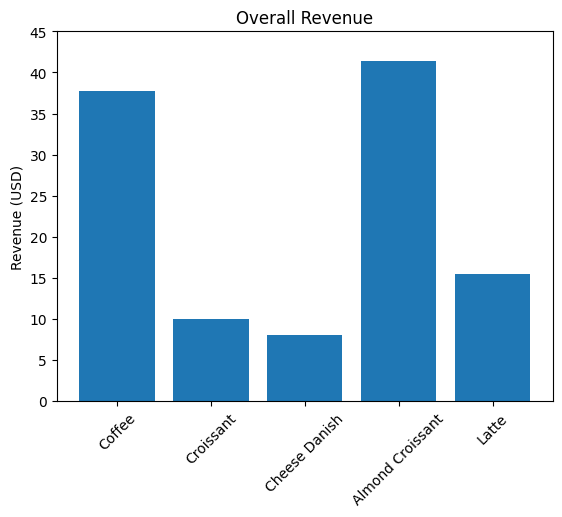

In [1178]:
plt.bar(filtered_items, filtered_values)
plt.title("Overall Revenue")
plt.xticks(rotation=45)
plt.ylabel(ycol)
plt.yticks(np.arange(0,ceil_max_dataframe(cafe_df, ycol=ycol, multiplier=increment), increment))
plt.show()

## Sold Count

In [1179]:
xcol, ycol = 'Item', 'Sold Count' # x and y columns from DataFrame to draw bar graph
filtered_items, filtered_values = remove_empty_bars(df=cafe_df, xcol=xcol, ycol=ycol) # removes items with no revenue
increment = 2 # incrementer for y values from the bar graph

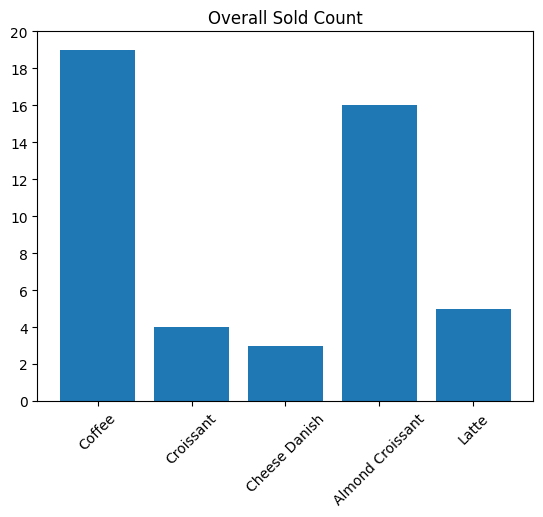

In [1180]:
plt.bar(filtered_items, filtered_values)
plt.title("Overall Sold Count")
plt.xticks(rotation=45)
plt.ylabel('')
plt.yticks(np.arange(0,ceil_max_dataframe(cafe_df, ycol=ycol, multiplier=increment), increment))
plt.show()

## Customer Item Quantity

In [1181]:
xcol, ycol = 'Order Number', 'Quantity' # target columns for x and y axes
customer_quantity_sum = order_df.groupby(xcol)[ycol].sum() # sums all customer item quantities
customer_names = order_df.get_all_customer_names() # gets all customer names by order
increment = 2 # incrementer for y values from the bar graph

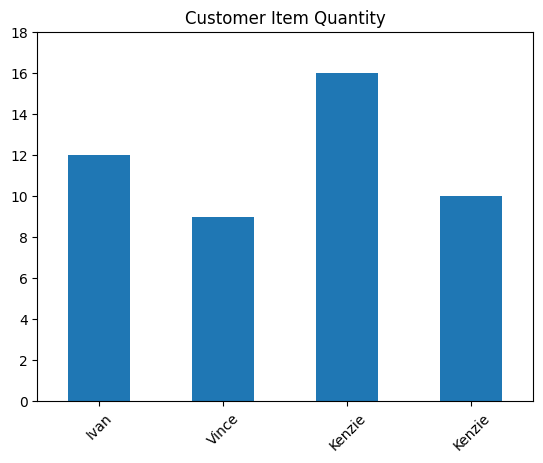

In [1182]:
customer_quantity_sum.plot(kind='bar')
plt.title("Customer Item Quantity")
plt.xticks(np.arange(len(customer_names)), labels=customer_names, rotation=45)
plt.xlabel('')
plt.yticks(np.arange(0,ceil_max_series(series=customer_quantity_sum, multiplier=increment), increment))
plt.ylabel('')
plt.show()